CSC2515 Project Part 2

By Kyle Oppenheimer and Brendan Kolisnik

Bert for distinguising between rotten tomatoes critics and amazon reviewers

This code was adapted from a tutorial from: https://mccormickml.com/2019/07/22/BERT-fine-tuning/#41-bertforsequenceclassification

In [ ]:
!pip install transformers

     |████████████████████████████████| 1.4MB 14.6MB/s 
     |████████████████████████████████| 2.9MB 56.7MB/s 
     |████████████████████████████████| 890kB 40.9MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=4ba372ff180d966a305112e8eec2b922f351b23bc64fc6abb8ad541fbac6ef36
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [ ]:
import torch
if torch.cuda.is_available():        
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [ ]:
import pandas as pd
import numpy as np
# df = pd.read_csv('./bert_df_10_percent.csv', index_col=0)
df = pd.read_csv('mix_df.csv', index_col = 0)
df

,review_content,dataSource
0,The original cast is back (sans one) and they ...,0.0
1,I really enjoyed this movie.Great story line. ...,0.0
2,I love this series and this latest one is of c...,0.0
3,"**1/2Fast Five, so named because it is the fif...",0.0
4,Slow to get going but after that.... lots of b...,0.0
...,...,...
199995,"Because we haven't been told what to think, th...",1.0
199996,It's a rare piece of family entertainment that...,1.0
199997,The strength of director Jacques Audiard's fil...,1.0
199998,"The film is beautiful to look at, rotoscoped w...",1.0


In [ ]:
# df[df['top_critic'] == True]['review_content'].sample(10).values
df[df['dataSource'] == 0]['review_content'].sample(10).values

array(["Why? Why do another Spider-man origin movie after it was done definitively by Sam Raimi and starring Toby Maguire in 2002? I had problems with the first Spider-man movie too, I found the Green Goblin to be very annoying for instance, but the origin story in Spiderman 1 with Toby Maguire was perfection! Sam Raimi's addition of biological based web spinners was an inspiration to the to the Spidey canon, so WHY go backwards and give the web-slinger mechanically based webs? How could a high school kid like Peter Parker afford super high tech web spinners, not to mention the refills! Why change the origin story from a nuclear irradiated spider that bites Peter Parker to a regular spider that may or may not have been genetically altered? Why make Peter Parker a jerk who, as soon as he acquires his powers becomes a bully who now bullies his former bully Flash, and then steals Flash's girlfriend. Don't worry, for some inexplicable reason, Flash forgives by the end of the movie.. Andrew

In [ ]:
# df[df['top_critic'] == False]['review_content'].sample(10).values
df[df['dataSource'] == 1]['review_content'].sample(10).values

array(["The action begins immediately, without even a title credit, and the movie ends abruptly and almost arbitrarily, as if we have witnessed an almost literal slice of life, snipped off at either end by a pair of editor's shears. Life -- and crime -- goes on.",
       'The documentary does a crucial job in presenting the work of such a fundamental figure to a new generation in a period in which the concept of criticism is quickly expanding - for good and evil. [Full review in Portuguese]',
       'Doggedly manipulative and yet consistently affecting, Broken piles on the miserablism to almost unbearable effect.',
       "A film that, in a non-Pixar dominated reality, would be cleaning up at the box office. It's enough to make you laugh.",
       'Forrest Gump is a schmaltz-Zelig, a Being There engineered from the genetic material of a Hallmark card.',
       'Not just a letdown but an absolute disaster.',
       'Ryan Gosling and Michael Pitt make a truly sinister pair of culprits.',

In [ ]:
subset_size = 200000
# df = df[:subset_size]
subset_df = df.sample(n=subset_size)

In [ ]:
print(subset_df.isna().sum(axis = 0))

review_content    3
dataSource        0
dtype: int64


In [ ]:
subset_df = subset_df[subset_df.review_content.notna()]

In [ ]:
# print(subset_df['top_critic'].value_counts()/len(subset_df)*100)
print(subset_df['dataSource'].value_counts()/len(subset_df)*100)

1.0    50.00075
0.0    49.99925
Name: dataSource, dtype: float64


In [ ]:
max_sentence_length = 32

In [ ]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(subset_df, test_size=0.1)

In [ ]:
sentences = train_df['review_content'].values
# labels = train_df['top_critic'].astype(int).values
labels = train_df['dataSource'].astype(int).values

In [ ]:
# Remove personal pronouns
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
from nltk.tokenize.treebank import TreebankWordDetokenizer

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [ ]:
# import re
# TAG_RE = re.compile(r'<[^>]+>')
# for i in range(len(sentences)):
  # The next four lines remove personal pronouns:
  # tokens = nltk.word_tokenize(sentences[i])
  # tagged = np.array(nltk.pos_tag(tokens))
  # sentences[i] = tagged[:,0][tagged[:,1] != 'PRP']
  # sentences[i] = TreebankWordDetokenizer().detokenize(sentences[i])

  # Remove spaces, special characters
  # sentences[i] = TAG_RE.sub('', sentences[i])
  # sentences[i] = re.sub('[^a-zA-Z]', ' ', sentences[i])
  # sentences[i] = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentences[i])
  # sentences[i] = re.sub(r'\s+', ' ', sentences[i])

In [ ]:
sentences[10:20]

array(["This proves to be a worthwhile companion bluray disc to the recent outstanding Thielemann Beethoven symphony set. (see my review.)I am not usually a big fan of combination pianist/conductor set-ups, but in this repertoire, I much prefer this version to the Barenboim set, good as it is.Buchbinder plays with a much lighter touch than Barenboim, and seems more whimsical.The tempi are considerably quicker. Plus you don't have to watch Barenboim mopping up his perspiration every few bars!  I really enjoyed #'s 1 & 3 here more than I usually do, due to his playing sensibilities. I've always been fond of #'s 2 & 5, but I still don't love #4. Buchbinder plays and conducts without a score, a sign of his knowing these concerti inside out. (I'm always skeptical of pianists that need a score in performance.) There just seems to be so much joy in his playing, and this infectiousness is evident in the orchestra members as well.What can you say about the Vienna Phil. and Beethoven? They are i

In [ ]:
labels[10:20]

array([0, 0, 0, 1, 1, 0, 0, 1, 0, 0])

In [ ]:
df[df['review_content'].str.len() < 100]['dataSource'].value_counts()/len(df)

1.0    0.162930
0.0    0.012125
Name: dataSource, dtype: float64

In [ ]:
from transformers import BertTokenizer

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
# tokenizer = BertTokenizer.from_pretrained('bert-base-cased', do_lower_case=False)

Loading BERT tokenizer...


In [ ]:
# Print the original sentence.
print(' Original: ', sentences[0])

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(sentences[0]))

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[0])))

 Original:  A film that not only couldn't stand up to the hype monster, but also couldn't stand up to multiple viewings.
Tokenized:  ['a', 'film', 'that', 'not', 'only', 'couldn', "'", 't', 'stand', 'up', 'to', 'the', 'h', '##ype', 'monster', ',', 'but', 'also', 'couldn', "'", 't', 'stand', 'up', 'to', 'multiple', 'viewing', '##s', '.']
Token IDs:  [1037, 2143, 2008, 2025, 2069, 2481, 1005, 1056, 3233, 2039, 2000, 1996, 1044, 18863, 6071, 1010, 2021, 2036, 2481, 1005, 1056, 3233, 2039, 2000, 3674, 10523, 2015, 1012]


In [ ]:
max_len = 0

# For every sentence...
for sent in sentences:

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(sent, add_special_tokens=True)

    # Update the maximum sentence length.
    max_len = max(max_len, len(input_ids))

print('Max sentence length: ', max_len)

Token indices sequence length is longer than the specified maximum sequence length for this model (552 > 512). Running this sequence through the model will result in indexing errors


Max sentence length:  13057


In [ ]:
# Tokenize all of the sentences and map the tokens to their word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in sentences:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = max_sentence_length,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                        truncation = True,
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Print sentence 0, now as a list of IDs.
print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2142: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Original:  A film that not only couldn't stand up to the hype monster, but also couldn't stand up to multiple viewings.
Token IDs: tensor([  101,  1037,  2143,  2008,  2025,  2069,  2481,  1005,  1056,  3233,
         2039,  2000,  1996,  1044, 18863,  6071,  1010,  2021,  2036,  2481,
         1005,  1056,  3233,  2039,  2000,  3674, 10523,  2015,  1012,   102,
            0,     0])


In [ ]:
from torch.utils.data import TensorDataset, random_split

# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, labels)

# Create a 90-10 train-validation split.

# Calculate the number of samples to include in each set.
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

161,997 training samples
18,000 validation samples


In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
batch_size = 32

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

In [ ]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model.cuda()
# model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [ ]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (30522, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (

In [ ]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )


In [ ]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs. The BERT authors recommend between 2 and 4. 
# We chose to run for 4, but we'll see later that this may be over-fitting the
# training data.
epochs = 2

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

# Function to calculate RMSE:
def flat_RMSE(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return (mean_squared_error(labels_flat, pred_flat))**(1/2)

In [ ]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


In [ ]:
import random
import numpy as np

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        # It returns different numbers of parameters depending on what arguments
        # arge given and what flags are set. For our useage here, it returns
        # the loss (because we provided labels) and the "logits"--the model
        # outputs prior to activation.
        outputs = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)
        loss = outputs.loss
        logits = outputs.logits
        # loss, logits = model(b_input_ids, 
        #                      token_type_ids=None, 
        #                      attention_mask=b_input_mask, 
        #                      labels=b_labels)

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_RMSE = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            # Get the "logits" output by the model. The "logits" are the output
            # values prior to applying an activation function like the softmax.
            outputs = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)
            loss = outputs.loss
            logits = outputs.logits
            # (loss, logits) = model(b_input_ids, 
            #                        token_type_ids=None, 
            #                        attention_mask=b_input_mask,
            #                        labels=b_labels)
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)

        total_eval_RMSE += flat_RMSE(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    avg_val_RMSE = total_eval_RMSE / len(validation_dataloader)
    print("  RMSE: {0:.2f}".format(avg_val_RMSE))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Valid. RMSE': avg_val_RMSE,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 2 ========
Training...
  Batch    40  of  5,063.    Elapsed: 0:00:08.
  Batch    80  of  5,063.    Elapsed: 0:00:16.
  Batch   120  of  5,063.    Elapsed: 0:00:25.
  Batch   160  of  5,063.    Elapsed: 0:00:33.
  Batch   200  of  5,063.    Elapsed: 0:00:41.
  Batch   240  of  5,063.    Elapsed: 0:00:50.
  Batch   280  of  5,063.    Elapsed: 0:00:58.
  Batch   320  of  5,063.    Elapsed: 0:01:07.
  Batch   360  of  5,063.    Elapsed: 0:01:16.
  Batch   400  of  5,063.    Elapsed: 0:01:25.
  Batch   440  of  5,063.    Elapsed: 0:01:34.
  Batch   480  of  5,063.    Elapsed: 0:01:43.
  Batch   520  of  5,063.    Elapsed: 0:01:52.
  Batch   560  of  5,063.    Elapsed: 0:02:02.
  Batch   600  of  5,063.    Elapsed: 0:02:12.
  Batch   640  of  5,063.    Elapsed: 0:02:21.
  Batch   680  of  5,063.    Elapsed: 0:02:30.
  Batch   720  of  5,063.    Elapsed: 0:02:40.
  Batch   760  of  5,063.    Elapsed: 0:02:49.
  Batch   800  of  5,063.    Elapsed: 0:02:58.
  Batch   840  of

In [ ]:
import pandas as pd

# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Valid. RMSE,Training Time,Validation Time
epoch,,,,,,
1,0.12,0.10,0.96,0.15,0:19:35,0:00:42
2,0.06,0.12,0.97,0.14,0:19:42,0:00:42


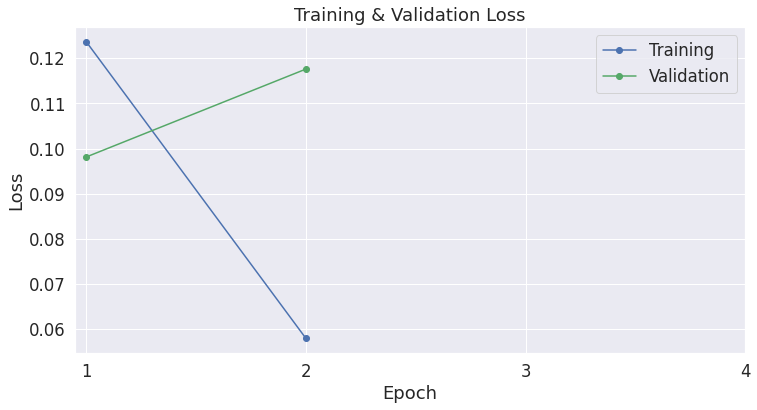

In [ ]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

In [ ]:
# import os

# # Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

# output_dir = './model_save/'

# # Create output directory if needed
# if not os.path.exists(output_dir):
#     os.makedirs(output_dir)

# print("Saving model to %s" % output_dir)

# # Save a trained model, configuration and tokenizer using `save_pretrained()`.
# # They can then be reloaded using `from_pretrained()`
# model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
# model_to_save.save_pretrained(output_dir)
# tokenizer.save_pretrained(output_dir)

# # Good practice: save your training arguments together with the trained model
# # torch.save(args, os.path.join(output_dir, 'training_args.bin'))

Saving model to ./model_save/


('./model_save/tokenizer_config.json',
 './model_save/special_tokens_map.json',
 './model_save/vocab.txt',
 './model_save/added_tokens.json')

In [ ]:
# Load a trained model and vocabulary that you have fine-tuned
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import BertTokenizer
output_dir = './model_save/'
# import transformers as ppb
# model_class, tokenizer_class, pretrained_weights = (ppb.BertModel, ppb.BertTokenizer, 'bert-base-uncased')
# model_class = BertForSequenceClassification.from_pretrained(
#     "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
#     num_labels = 2, # The number of output labels--2 for binary classification.
#                     # You can increase this for multi-class tasks.   
#     output_attentions = False, # Whether the model returns attentions weights.
#     output_hidden_states = False, # Whether the model returns all hidden-states.
# )

# model = model_class.from_pretrained(output_dir)
# tokenizer = tokenizer_class.from_pretrained(output_dir)

# Comment from blog post:
#Just replace model_class by BertForSequenceClassification
#and tokenizer_class by BertTokenizer
#Haven't tried this yet
model = BertForSequenceClassification.from_pretrained(output_dir)
tokenizer = BertTokenizer.from_pretrained(output_dir)

# Copy the model to the GPU.
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [ ]:
import pandas as pd

# Report the number of sentences.
print('Number of test sentences: {:,}\n'.format(test_df.shape[0]))

sentences = test_df['review_content'].values
# import re
# TAG_RE = re.compile(r'<[^>]+>')
# for i in range(len(sentences)):
  # The next four lines remove personal pronouns:
  # tokens = nltk.word_tokenize(sentences[i])
  # tagged = np.array(nltk.pos_tag(tokens))
  # sentences[i] = tagged[:,0][tagged[:,1] != 'PRP']
  # sentences[i] = TreebankWordDetokenizer().detokenize(sentences[i])

  # Remove spaces, special characters
  # sentences[i] = TAG_RE.sub('', sentences[i])
  # sentences[i] = re.sub('[^a-zA-Z]', ' ', sentences[i])
  # sentences[i] = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentences[i])
  # sentences[i] = re.sub(r'\s+', ' ', sentences[i])
# labels = test_df.top_critic.astype(int).values
labels = test_df.dataSource.astype(int).values


# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in sentences:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = max_sentence_length,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                        truncation = True,
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Set the batch size.  
batch_size = 32  

# Create the DataLoader.
prediction_data = TensorDataset(input_ids, attention_masks, labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

Number of test sentences: 20,000



/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2142: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 20,000 test sentences...
    DONE.


In [ ]:
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score

# RMSE error metric:
# Combine the results across all batches. 
flat_predictions = np.concatenate(predictions, axis=0)

# For each sample, pick the label (0 or 1) with the higher score.
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = np.concatenate(true_labels, axis=0)

# Calculate the MCC
mcc = matthews_corrcoef(flat_true_labels, flat_predictions)

print('Total MCC: %.3f' % mcc)
print(f'RMSE: {(mean_squared_error(flat_true_labels, flat_predictions))**(1/2)}')
print(f'Accuracy: {accuracy_score(flat_true_labels, flat_predictions, normalize = True)}')

Total MCC: 0.932
RMSE: 0.1847971861257633
Accuracy: 0.96585


In [ ]:
np.concatenate(predictions, axis=0)

array([[-4.656229 ,  4.3459578],
       [-4.5747957,  4.21841  ],
       [ 4.7146425, -4.4718833],
       ...,
       [ 4.7917366, -4.5098505],
       [-4.6537933,  4.291176 ],
       [-4.352566 ,  4.058326 ]], dtype=float32)

In [ ]:
sentences[(flat_predictions == 0) & (flat_true_labels == 1)]

array(["It is funny at times and shows that even he has a sense of humor about himself. It's just a shame what direction he chose to take the film because I feel had he taken in seriously, instead of trying to shock us, he might have actual touched on something",
       'There are movies willed to life by the passion of their creators, and there are movies like Green Lantern, which are willed to life strictly by market forces.',
       'Title implies the immigrant experience in modern America; but such a plot is only a backdrop for a bitter/sweet story about a close family dealing with the death of a child.',
       "What's a nubile young monarch to do? Why, head to the States and school the nature-hating, money-grubbing Yanks with some hearty forbidden dancing, of course!",
       "Russell Brand creates a distinctive character based on his own persona, rather than trying to mimic Dudley Moore. He is by turns hilarious and touching, with an inner core of sweetness we haven't seen from 

In [ ]:
sentences[(flat_predictions == 1) & (flat_true_labels == 0)]

array(["Like the first Zeitgeist, this is eye-opening (if you have that capability). The analysis of economics and supply side magic-of-the-market crap is worth the price of admission. The product-vs-money economy makes perfect sustainable sense. The problem is that the situation isn't dire enough for significant numbers of citizens to want a change. Humans are irrationally optimistic and will not change until forced to, which hasn't happened yet.The upside is that a tiny number of humans are realistic and spend useful time evaluating what options may exist if the current system crashes. They are the only hope humans have for long term survival. When the oil resources suddenly vanish, human population will head back down toward the sustainable 200M world population number and if these folks are among who is left, humanity might have a future.",
       "DIRTY MARY, CRAZY LARRY basically plays like the actors were strapped into a car going like a bat and just ad-libbed the entire movie a

In [ ]:
sentences[(flat_predictions == 0) & (flat_true_labels == 0)]

array(["I've been a huge DOCTOR WHO fan since the very first doctor! I've enjoyed every doctor(withn the exception of Sylvester McCoy)and really like Matt Smith. This episode was really great,and I REALLY, REALLY ENJOYED IT! So glad I was able to buy it.",
       "This movie was very interesting!  It wasn't entirely what I thought it would be, which was like a Rip-off of X-Men.  The story takes a much different turn and I really like the direction in how they chose to tell the story.  If you didn't like Hollywood Homicide or Teenage Mutant Ninja Turtles III You'll like this movie!",
       "QT's losing the magic touch.  I thought so with Inglourious Bastards and I think so again.  Fabulous dialogue, superb.  But honestly there were certain deaths in both movies that were gratutious and unnecessary and ruined the film.  Dr. Schultz didn't need to die, and neither did Bridget von Hammersmark...over the top  And Django especially REALLY dragged on and on.  Where is the editing?  Is Tarant

In [ ]:
sentences[(flat_predictions == 1) & (flat_true_labels == 1)]

array(["Let's just say Travolta and Idina Menzel had more chemistry, and leave it at that.",
       'With lackluster storytelling and character development, Immortals is truly a visual victory, but nothing more.',
       "It's all talk and no action.", ...,
       'Idris Elba and Kate Winslet sell the characters and situation fully, establishing a deep relationship that will enthrall audiences.',
       'A riveting and powerful drama about a 15-year-old girl torn by a simple question: Where is her home?',
       "Kidnap's clumsy clunkiness, exposition-heavy monologues and inferior story keep it in that late-night cable category that seems perfectly entertaining so long as you aren't paying for it."],
      dtype=object)

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(flat_true_labels, flat_predictions) # row = true_label, cols = pred

array([[9750,  346],
       [ 337, 9567]])

In [ ]:
confusion_matrix(flat_true_labels, flat_predictions, normalize = 'all')

array([[0.4875 , 0.0173 ],
       [0.01685, 0.47835]])

In [ ]:
confusion_matrix(flat_true_labels, flat_predictions, normalize = 'true')

array([[0.965729  , 0.034271  ],
       [0.03402666, 0.96597334]])

In [ ]:
confusion_matrix(flat_true_labels, flat_predictions, normalize = 'pred')

array([[0.96659066, 0.03490366],
       [0.03340934, 0.96509634]])

In [ ]:
from scipy.special import softmax
softmax_predictions = softmax(np.concatenate(predictions, axis=0), axis = 1)
confidence_threshold = 0.995 # require better confidence than 20%
confident_predictions = softmax_predictions.copy()
confident_predictions[confident_predictions < confidence_threshold] = 0
flat_confident_predictions = np.argmax(confident_predictions, axis=1).flatten()
np.unique(flat_confident_predictions, return_counts=True)

(array([0, 1]), array([11750,  8250]))

In [ ]:
confident_predictions

array([[0.        , 0.999877  ],
       [0.        , 0.99984837],
       [0.9998975 , 0.        ],
       ...,
       [0.9999089 , 0.        ],
       [0.        , 0.9998698 ],
       [0.        , 0.9997778 ]], dtype=float32)

In [ ]:
non_confident_prediction_indices = confident_predictions.sum(axis=1) == 0 
non_confident_prediction_indices

array([False, False, False, ..., False, False, False])

In [ ]:
# Confident RMSE:
print(f'RMSE: {(mean_squared_error(flat_true_labels[~non_confident_prediction_indices], flat_confident_predictions[~non_confident_prediction_indices]))**(1/2)}')

RMSE: 0.07690055384206734


In [ ]:
flat_final_predictions = flat_confident_predictions.copy().astype(float)
print(f'Confident predictions: {np.sum(~non_confident_prediction_indices)/len(non_confident_prediction_indices)*100}%')
# flat_final_predictions

Confident predictions: 85.395%


In [ ]:
# Try turning softmax into a weighted average:
print(np.shape(softmax_predictions))
softmax_predictions

(20000, 2)


array([[1.2312508e-04, 9.9987698e-01],
       [1.5173759e-04, 9.9984837e-01],
       [9.9989748e-01, 1.0239954e-04],
       ...,
       [9.9990892e-01, 9.1270980e-05],
       [1.3037458e-04, 9.9986982e-01],
       [2.2238205e-04, 9.9977779e-01]], dtype=float32)

In [ ]:
soft_weighted_avg_preds = softmax_predictions @ [0,1]
soft_weighted_avg_preds

array([9.99876976e-01, 9.99848366e-01, 1.02399543e-04, ...,
       9.12709802e-05, 9.99869823e-01, 9.99777794e-01])

In [ ]:
print(f'RMSE: {(mean_squared_error(flat_true_labels, soft_weighted_avg_preds))**(1/2)}')

RMSE: 0.17029174547936846


In [ ]:
# What do really confident sentences look like?
print(sentences[~non_confident_prediction_indices])
print(flat_final_predictions[~non_confident_prediction_indices])
print(flat_true_labels[~non_confident_prediction_indices])

["Let's just say Travolta and Idina Menzel had more chemistry, and leave it at that."
 'With lackluster storytelling and character development, Immortals is truly a visual victory, but nothing more.'
 "I've been a huge DOCTOR WHO fan since the very first doctor! I've enjoyed every doctor(withn the exception of Sylvester McCoy)and really like Matt Smith. This episode was really great,and I REALLY, REALLY ENJOYED IT! So glad I was able to buy it."
 ...
 'i love this movie.it made me laugh and cry.normally im more a action/adventure movie girl but this movie changed me alittle bit.it made me believe that some crushes never change.'
 'A riveting and powerful drama about a 15-year-old girl torn by a simple question: Where is her home?'
 "Kidnap's clumsy clunkiness, exposition-heavy monologues and inferior story keep it in that late-night cable category that seems perfectly entertaining so long as you aren't paying for it."]
[1. 1. 0. ... 0. 1. 1.]
[1 1 0 ... 0 1 1]


In [ ]:
sentences[~non_confident_prediction_indices][flat_true_labels[~non_confident_prediction_indices] != flat_final_predictions[~non_confident_prediction_indices]]

array(['I was hoping I would enjoy it like I enjoyed Ratchet and Clank (yep, I liked that film). Unfortunately it was not to be.',
       'Doris is an extraordinary character who grabs the reins of her life after a lifetime of sacrifice for others. While her actions are rather unusual, her feelings are recognizable, and anyone can identify with her bid to shake up things.',
       "Although one must ask, 'Why remake a nearly perfect Hitchcock masterpiece?' there's no getting around that this 1959 technicolor thriller is thoroughly likeable in itself.  While lacking the original's taut pacing (and hence its sense of menace), snappy dialog and cutting-edge camerawork, the mostly UK cast here-- deftly led by the underappreciated Kenneth More-- makes this breezy update well worth watching.  Recommended especially for fans of the post-WWII period in British film.  3 1/2 stars.",
       'A fantasy for the ages, for all ages. Laugh out loud funny, touching, sweet, tender, filled with action f

In [ ]:
labels[~non_confident_prediction_indices][flat_true_labels[~non_confident_prediction_indices] != flat_final_predictions[~non_confident_prediction_indices]]

tensor([1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1,
        0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1,
        1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1,
        1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0,
        1, 1, 0, 0, 1])

Make predictions on just amazon data:

In [ ]:
import pandas as pd
# prediction_df = pd.read_pickle('train_sample.pkl')
# prediction_df = pd.read_csv('new_train_sample.csv', index_col = 0, delimiter=',')
prediction_df = pd.read_csv('new_test_sample.csv', index_col = 0)
prediction_df

,reviewText
646479,The rhythm of the Blues is birthed down and di...
432444,This adaptation of the novel Les Liaisons Dang...
1297267,Compelling storytelling... Beautiful art direc...
1390010,"T obe clear, this is a review ofThe Walking De..."
226942,This rich little horror film about a single mo...
...,...
1317496,"A touching tale of love, devotion through the ..."
90991,This is a truly great movie. When ever I sens...
8564,"Released in 1993, Bruce Willis' &#34;Striking ..."
876721,"Return to Peyton Place, 1961 filmAllison MacKe..."


In [ ]:
prediction_df.isna().sum(axis=0)

reviewText    3
dtype: int64

In [ ]:
prediction_df[prediction_df.isna()] = ' '

In [ ]:
prediction_df.isna().sum(axis=0)

reviewText    0
dtype: int64

In [ ]:
prediction_df

,reviewText
646479,The rhythm of the Blues is birthed down and di...
432444,This adaptation of the novel Les Liaisons Dang...
1297267,Compelling storytelling... Beautiful art direc...
1390010,"T obe clear, this is a review ofThe Walking De..."
226942,This rich little horror film about a single mo...
...,...
1317496,"A touching tale of love, devotion through the ..."
90991,This is a truly great movie. When ever I sens...
8564,"Released in 1993, Bruce Willis' &#34;Striking ..."
876721,"Return to Peyton Place, 1961 filmAllison MacKe..."


In [ ]:
import numpy as np
sentences = prediction_df['reviewText'].values
# import re
# TAG_RE = re.compile(r'<[^>]+>')
# for i in range(len(sentences)):
  # The next four lines remove personal pronouns:
  # tokens = nltk.word_tokenize(sentences[i])
  # tagged = np.array(nltk.pos_tag(tokens))
  # sentences[i] = tagged[:,0][tagged[:,1] != 'PRP']
  # sentences[i] = TreebankWordDetokenizer().detokenize(sentences[i])

  # Remove spaces, special characters
  # sentences[i] = TAG_RE.sub('', sentences[i])
  # sentences[i] = re.sub('[^a-zA-Z]', ' ', sentences[i])
  # sentences[i] = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentences[i])
  # sentences[i] = re.sub(r'\s+', ' ', sentences[i])
# labels = test_df.top_critic.astype(int).values
labels = np.zeros(len(sentences))

In [ ]:
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

import pandas as pd

# Report the number of sentences.
print('Number of test sentences: {:,}\n'.format(prediction_df.shape[0]))

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in sentences:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = max_sentence_length,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                        truncation = True,
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Set the batch size.  
batch_size = 32  

# Create the DataLoader.
prediction_data = TensorDataset(input_ids, attention_masks, labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

Number of test sentences: 24,713



/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2142: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 24,713 test sentences...
    DONE.


In [ ]:
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score

# RMSE error metric:
# Combine the results across all batches. 
flat_predictions = np.concatenate(predictions, axis=0)

# For each sample, pick the label (0 or 1) with the higher score.
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = np.concatenate(true_labels, axis=0)

# Calculate the MCC
mcc = matthews_corrcoef(flat_true_labels, flat_predictions)

print('Total MCC: %.3f' % mcc)
print(f'RMSE: {(mean_squared_error(flat_true_labels, flat_predictions))**(1/2)}')
print(f'Accuracy: {accuracy_score(flat_true_labels, flat_predictions, normalize = True)}')

Total MCC: 0.000
RMSE: 0.3455001763661732
Accuracy: 0.8806296281309433


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(flat_true_labels, flat_predictions) # row = true_label, cols = pred

array([[21763,  2950],
       [    0,     0]])

In [ ]:
sentences[flat_predictions == 1]

array(["The rhythm of the Blues is birthed down and dirty like Georgia clay or Mississippi mud. It is where the musician's feet seek out the surface to beat against which matches the cadence of the emotional flow that first quickens the heart to react discordantly to the pain of love gone wrong. As Son House, legendary blues singer and guitarist, tells us: I'm talkin' about the Blues... When two people, supposed to be in love, when one or the other deceives the other through their love... It starts with a wail, a scream, a guttural cry from the throat of a seasoned songster or, maybe a saxophone will tell that part, and next the story behind it all is laid out in spades. Then, we cry. The Blues. There is nothing better on earth by which to heal a broken heart, whether that broken heart be from a failed marriage, loss of a loved one, a broken friendship for no good reason under the sun... All loss is like death, and listening to the blues is like having someone, even a stranger we just 

In [ ]:
from scipy.special import softmax
softmax_predictions = softmax(np.concatenate(predictions, axis=0), axis = 1)
confidence_threshold = 0.995 # require better confidence than 20%
confident_predictions = softmax_predictions.copy()
confident_predictions[confident_predictions < confidence_threshold] = 0
flat_confident_predictions = np.argmax(confident_predictions, axis=1).flatten()
np.unique(flat_confident_predictions, return_counts=True)

(array([0, 1]), array([24192,   521]))

In [ ]:
non_confident_prediction_indices = confident_predictions.sum(axis=1) == 0 
non_confident_prediction_indices

array([ True,  True,  True, ..., False, False, False])

In [ ]:
flat_final_predictions = flat_confident_predictions.copy().astype(float)
print(f'Confident predictions: {np.sum(~non_confident_prediction_indices)/len(non_confident_prediction_indices)*100}%')
# flat_final_predictions

Confident predictions: 67.04973091085662%


In [ ]:
# What do really confident sentences look like?
print(sentences[~non_confident_prediction_indices])
print(flat_final_predictions[~non_confident_prediction_indices])
print(flat_true_labels[~non_confident_prediction_indices])

["T obe clear, this is a review ofThe Walking Dead:  Season One [Blu-ray]. This includes, but is not limited to the series itself but also the actual technical aspects of the Blu Ray release.The Walking Dead is a small screen adaptation of an ongoing comic book series by the same name. You can find the first part of the series collected inThe Walking Dead:  Compendium One.The story goes that a sheriff's deputy is taken to the hospital after being shot by criminals. When he awakens quite some time seems to have passed and the hospital is empty... with the exception of some dead people and a door with a very odd warning. The series involves Rick trying to reunite with his wife and son while avoiding being bitten by the walking dead. Eventually he hooks up with other survivors, getting ever closer to just what is going on.From what I understand, the TV series takes some liberties with the original comic books story, but tries to remain as true as possible to the source. I have not read th

In [ ]:
# Are there any confident 1s?
confident_1s = sentences[~non_confident_prediction_indices & (flat_final_predictions == 1)]
print(len(confident_1s))
confident_1s

521


array(["Ben Affleck's second directorial effort is based on the novel Prince of Thieves by Chuck Hogan, with a screenplay by Peter Craig, Affleck, and Aaron Stockard, who co-wrote the screenplay for Affleck's first filmGone Baby Gone. Taking place in Boston, an area which Affleck is quite familiar with, The Town is a heist movie that has been inevitably compared to Heat with few mentioning how it compares to recent ventures into the heist sub-genre. In comparison to most of the mindless, non-stop action heist movies that have been released in the last few years, The Town is a welcome return to the heist films that had both story and characters that were more than mere pawns of the screenplay. As a whole, The Town is a terrific, though imperfect film expertly handled by its unlikely director who has proven himself a worthy director with his two films.One blue-collar Boston neighborhood has produced more bank robbers and armored car thieves than anywhere in the world. Charlestown. While 

In [ ]:
from scipy.special import softmax
softmax_predictions = softmax(np.concatenate(predictions, axis=0), axis = 1)
softmax_predictions

array([[8.6563174e-03, 9.9134350e-01],
       [9.9482310e-01, 5.1770187e-03],
       [9.6827745e-01, 3.1722520e-02],
       ...,
       [9.9984026e-01, 1.5954432e-04],
       [9.9541503e-01, 4.5850556e-03],
       [9.9950993e-01, 4.9005117e-04]], dtype=float32)

In [ ]:
soft_weighted_avg_preds = softmax_predictions @ [0,1]
soft_weighted_avg_preds
prediction_df['expertise'] = soft_weighted_avg_preds
prediction_df

,reviewText,expertise
646479,The rhythm of the Blues is birthed down and di...,0.991343
432444,This adaptation of the novel Les Liaisons Dang...,0.005177
1297267,Compelling storytelling... Beautiful art direc...,0.031723
1390010,"T obe clear, this is a review ofThe Walking De...",0.000121
226942,This rich little horror film about a single mo...,0.128841
...,...,...
1317496,"A touching tale of love, devotion through the ...",0.999154
90991,This is a truly great movie. When ever I sens...,0.000227
8564,"Released in 1993, Bruce Willis' &#34;Striking ...",0.000160
876721,"Return to Peyton Place, 1961 filmAllison MacKe...",0.004585


In [ ]:
prediction_df.sample(10)

,reviewText,expertise
788395,"A good bargain. It's used, but in pretty good ...",0.000114
677467,Sahara is a 1943 black and white film made dur...,0.001885
498488,Virginity is up against some stiff competition...,0.000300
1306515,I walked out of this film in the theater. Bot...,0.001144
781108,"Yes, yes, you may rightly ask, How dare they m...",0.020393
275746,"Did ya see Al Jolson at the Schubert? Yeah, he...",0.317305
142284,This in my top three westerns of all time.The ...,0.000209
860310,"The Sixth Sense, Unbreakable, and Signs are th...",0.008883
474538,M. Night Shyamalan hit a towering home-run wit...,0.057278
244093,Viewed: 11/13Rate: 1011/13: I am not sure why ...,0.001723


In [ ]:
prediction_df.to_csv('test_STC.csv')

In [ ]:
# Output soft_weighted_avg_preds with np.save(.npy) to save space
np.save('test_STC.npy', soft_weighted_avg_preds)

In [ ]:
# # Lets do some svm on this data set and then maybe combine them
# # We want the default likely to be the global average not the downsamples one for svm...
# !pip install surprise
# from surprise import Dataset
# from surprise import Reader
# from surprise import SVD
# import time

In [ ]:
# from surprise.model_selection import train_test_split
# surprise_df = full_df[:190000][['reviewerID', 'itemID', 'overall']]
# surprise_df.columns = ['user', 'item', 'rating']
# reader = Reader(rating_scale=(1, 5))
# surprise_data = Dataset.load_from_df(surprise_df[["user", "item", "rating"]], reader)
# surprise_train, surprise_test = train_test_split(surprise_data, test_size=.25)

In [ ]:
# from surprise import accuracy
# algo = SVD()
# start = time.time()
# algo.fit(surprise_train)
# end = time.time()
# print(end - start)

# svd_preds = algo.test(surprise_test)
# accuracy.rmse(svd_preds)

8.573986768722534
RMSE: 0.9334


0.9333949399378925

In [ ]:
# # combine svd and bert
# # remember to subtract 1 from svd preds
# surprise_df = test_df[['reviewerID', 'itemID', 'overall']]
# surprise_df.columns = ['user', 'item', 'rating']
# reader = Reader(rating_scale=(1, 5))
# surprise_data = Dataset.load_from_df(surprise_df[["user", "item", "rating"]], reader)
# surprise_train, surprise_test = train_test_split(surprise_data, test_size=1.0)

In [ ]:
# test_svd_preds = algo.test(surprise_test)
# accuracy.rmse(test_svd_preds)

RMSE: 0.9246


0.9246320404857364

In [ ]:
# test_svd_df = pd.DataFrame(test_svd_preds)
# flat_svd_predictions = test_svd_df.est.values
# flat_svd_predictions

array([4.55419376, 4.44649756, 3.96495932, ..., 4.7401331 , 4.43299365,
       2.98203006])

In [ ]:
# flat_final_predictions = flat_confident_predictions.copy().astype(float)
# flat_final_predictions[non_confident_prediction_indices] = flat_svd_predictions[non_confident_prediction_indices] - 1
# print(f'Confident predictions: {np.sum(~non_confident_prediction_indices)/len(non_confident_prediction_indices)*100}%')
# flat_final_predictions

Confident predictions: 62.30607546792113%


array([2.        , 4.        , 2.96495932, ..., 2.        , 3.43299365,
       4.        ])

In [ ]:
# flat_true_labels

array([2, 4, 4, ..., 2, 4, 4])

In [ ]:
# print(f'RMSE: {(mean_squared_error(flat_true_labels, flat_final_predictions))**(1/2)}')

RMSE: 0.7923746804206544
